# Digit Recognizer

Notebook with digit recognizer dataset experiments using decision tree and random forest classification models

https://www.kaggle.com/competitions/digit-recognizer/overview

# Intro & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import numpy as np

In [2]:
from pathlib import Path
from mlpeople.io.google_drive import download_file_iss

train_file_path = Path('./downloads/digits_train.csv')
test_file_path = Path('./downloads/digits_test.csv')

# download only if files does NOT exist
if not train_file_path.exists():
    print("Downloading train file...")
    download_file_iss(
        '1cSDfLDKY4pLwL5VkxAgUkUMjmFG60hwq',
        output_path=str(train_file_path)
    )
else:
    print("Train file already exists. Skipping download.")

if not test_file_path.exists():
    print("Downloading test file...")
    download_file_iss(
        '1xxp6YmVnFoFADVIMfH8Se8skebguQrV5',
        output_path=str(test_file_path)
    )
else:
    print("Test file already exists. Skipping download.")

# read csv
raw_df = pd.read_csv(train_file_path)
raw_df.head()

Train file already exists. Skipping download.
Test file already exists. Skipping download.


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = raw_df.iloc[:, 0]  # first column = target
X = raw_df.iloc[:, 1:] # remaining columns = features

# Display Rows (Digits)

In [4]:
from mlpeople.visualization.images.display import (
    show_image_matplotlib,
    print_image_ascii
)

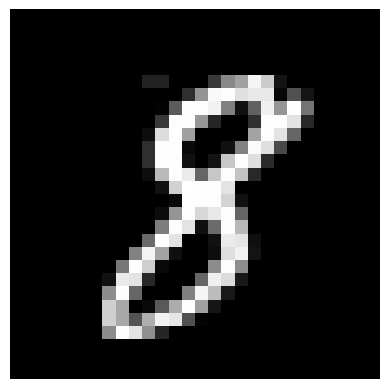

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 03434 0 0 05713616224520319 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 047147249253224232232 68121 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3912542532421281797240149254115 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 05725325415138 0 04725325322840 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 013221254160 0 0 0 0164254228102 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 047253253 9 0 01713025122373 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 04725325317 01919925422342 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 01318625323510119925319540 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 017210255254254228 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 925425325321117 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 011149254215232253101 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0125

In [46]:
# Matplotlib
show_image_matplotlib(X.iloc[20], normalize=True)

# ASCII
print_image_ascii(X.iloc[20], scale_to_9=False)

# Split train test

In [6]:
from sklearn.model_selection import train_test_split

def get_train_test_split(target_col="label", random_state=42):
  train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=random_state)

  y_train = train_df[target_col]
  y_val = val_df[target_col]

  X_train_cols = train_df.drop(target_col, axis=1).columns.to_list()
  X_val_cols = val_df.drop(target_col, axis=1).columns.to_list()

  X_train = train_df[X_train_cols]
  X_val = val_df[X_val_cols]

  return (X_train, y_train, X_val, y_val)

In [7]:
X_train, y_train, X_val, y_val = get_train_test_split()

# Scaling

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_processing(mode='standard', X_train=X_train, X_val=X_val):
  if (mode == 'standard'):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()

  X_train_cols = X_train.columns.to_list()

  X_train[X_train_cols] = scaler.fit_transform(X_train[X_train_cols])
  X_val[X_train_cols] = scaler.transform(X_val[X_train_cols])

  return (X_train, X_val)

In [9]:
X_train.iloc[20].describe()

count    784.000000
mean      26.543367
std       71.315790
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      255.000000
Name: 16573, dtype: float64

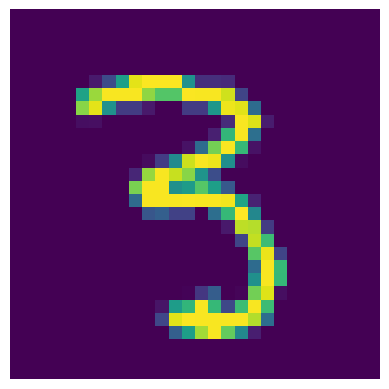

In [10]:
show_image_matplotlib(X_train.iloc[2], cmap="viridis")

In [11]:
X_train, X_val = scale_processing(mode='normalized')

In [12]:
X_train.iloc[20].describe()

count    784.000000
mean       0.104092
std        0.279670
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: 16573, dtype: float64

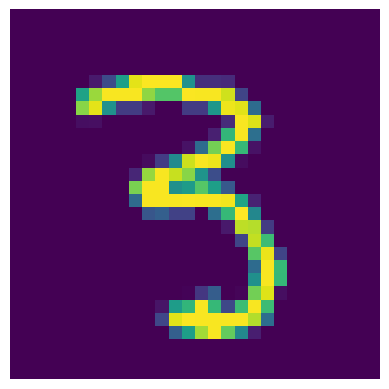

In [43]:
show_image_matplotlib(X_train.iloc[2], cmap="viridis")

# One Desicion Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [18]:
dt_model.tree_.n_leaves

np.int64(2595)

In [20]:
print(export_text(dt_model, feature_names=X_train.columns, max_depth=2))

|--- pixel409 <= 0.00
|   |--- pixel434 <= 0.00
|   |   |--- pixel455 <= 0.02
|   |   |   |--- truncated branch of depth 15
|   |   |--- pixel455 >  0.02
|   |   |   |--- truncated branch of depth 26
|   |--- pixel434 >  0.00
|   |   |--- pixel375 <= 0.00
|   |   |   |--- truncated branch of depth 34
|   |   |--- pixel375 >  0.00
|   |   |   |--- truncated branch of depth 19
|--- pixel409 >  0.00
|   |--- pixel155 <= 0.00
|   |   |--- pixel239 <= 0.00
|   |   |   |--- truncated branch of depth 33
|   |   |--- pixel239 >  0.00
|   |   |   |--- truncated branch of depth 39
|   |--- pixel155 >  0.00
|   |   |--- pixel657 <= 0.00
|   |   |   |--- truncated branch of depth 26
|   |   |--- pixel657 >  0.00
|   |   |   |--- truncated branch of depth 22



In [21]:
train_preds = dt_model.predict(X_train)
val_preds = dt_model.predict(X_val)
accuracy_score(y_train, train_preds)

1.0

In [22]:
accuracy_score(y_val, val_preds)

0.853452380952381

## Prediction Validataion Example

In [23]:
val_preds[31], y_val.iloc[31]

(np.int64(6), np.int64(6))

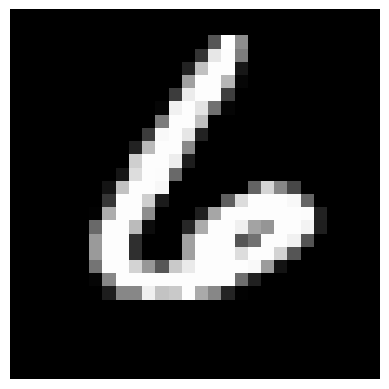

In [24]:
show_image_matplotlib(pd.Series(X_val.iloc[31]))

## Max Depth

In [25]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_val, y_val)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [26]:
%%time
max_depth_errors_df = pd.DataFrame([max_depth_error(md) for md in range(2, 21, 2)])

CPU times: user 23.7 s, sys: 1.09 s, total: 24.7 s
Wall time: 25.3 s


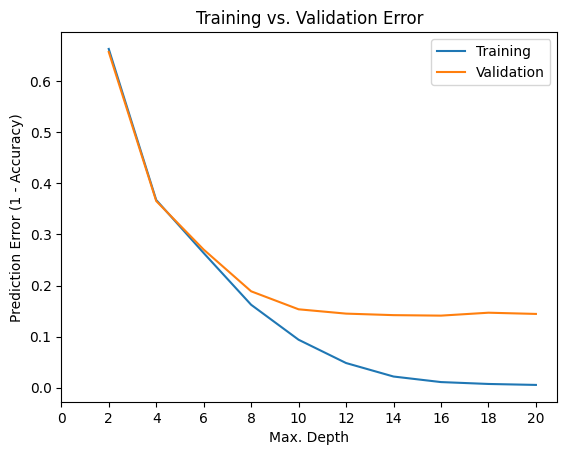

In [27]:
plt.figure()
plt.plot(max_depth_errors_df['Max Depth'], max_depth_errors_df['Training Error'])
plt.plot(max_depth_errors_df['Max Depth'], max_depth_errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

In [28]:
dt_model_13 = DecisionTreeClassifier(max_depth=13, random_state=42)
dt_model_13.fit(X_train, y_train)

train_preds_13 = dt_model_13.predict(X_train)
val_preds_13 = dt_model_13.predict(X_val)
accuracy_score(y_train, train_preds_13)

0.9669642857142857

In [30]:
accuracy_score(y_val, val_preds_13)

0.8536904761904762

# RandomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 14.2 s, sys: 278 ms, total: 14.5 s
Wall time: 2.53 s


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [33]:
train_rf_preds = rf_model.predict(X_train)
val_rf_preds = rf_model.predict(X_val)
accuracy_score(y_train, train_rf_preds)

1.0

In [34]:
accuracy_score(y_val, val_rf_preds)

0.9654761904761905

## N estimators

In [35]:
def n_estimator_error_rf(n):
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_val, y_val)
    return {'N Estimators': n, 'Training Error': train_acc, 'Validation Error': val_acc}

In [36]:
%%time
n_estimator_errors_df = pd.DataFrame([n_estimator_error_rf(n) for n in range(10, 120, 10)])

CPU times: user 1min 12s, sys: 2.13 s, total: 1min 14s
Wall time: 1min 16s


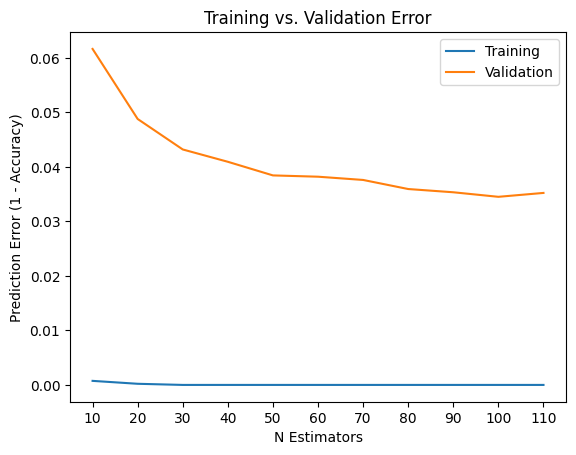

In [38]:
plt.figure()
plt.plot(n_estimator_errors_df['N Estimators'], n_estimator_errors_df['Training Error'])
plt.plot(n_estimator_errors_df['N Estimators'], n_estimator_errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(10, 120, 10))
plt.xlabel('N Estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

## Randomized Search Hyperparam tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV

In [43]:
%%time
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
params_rf = {
    'n_estimators': range(10,200,10),
    'max_depth': range(5,20,2),
    'min_samples_split': range(2,10,2),
    'min_samples_leaf': range(1,7,1),
    'max_leaf_nodes': range(128, 4000, 128)
}

rf_rs = RandomizedSearchCV(
    rf_model,
    params_rf,
    cv=4,
    scoring='accuracy',
    n_iter=40,
    n_jobs=-1,
)


rf_rs.fit(X_train, y_train)
rf_model_best = rf_rs.best_estimator_
print(rf_rs.best_params_)

/opt/miniconda3/envs/mlpeople4/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_leaf_nodes': 3200, 'max_depth': 19}
CPU times: user 31.5 s, sys: 31.9 s, total: 1min 3s
Wall time: 4min 30s


In [44]:
train_rf_preds = rf_model_best.predict(X_train)
val_rf_preds = rf_model_best.predict(X_val)
accuracy_score(y_train, train_rf_preds)

0.9963690476190477

In [45]:
accuracy_score(y_val, val_rf_preds)

0.9605952380952381

## Errors Samples

True - 8.0, predicted - 6.0


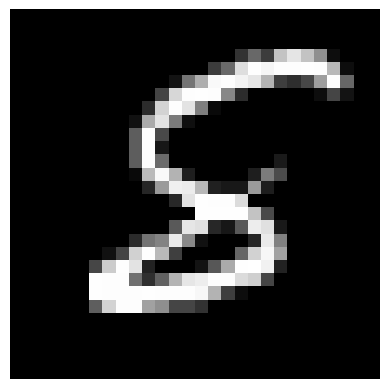

____________________________________________________________

True - 8.0, predicted - 4.0


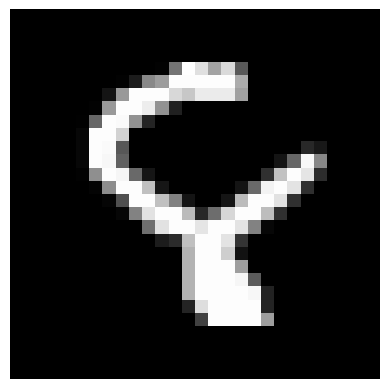

____________________________________________________________

True - 7.0, predicted - 9.0


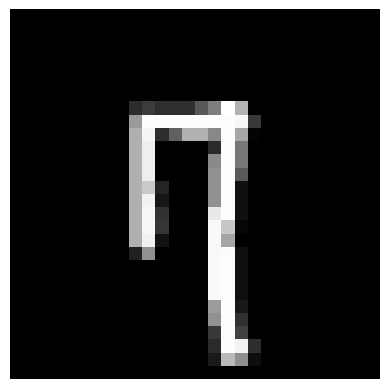

____________________________________________________________

True - 0.0, predicted - 6.0


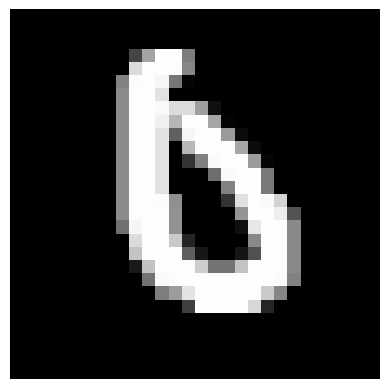

____________________________________________________________

True - 5.0, predicted - 7.0


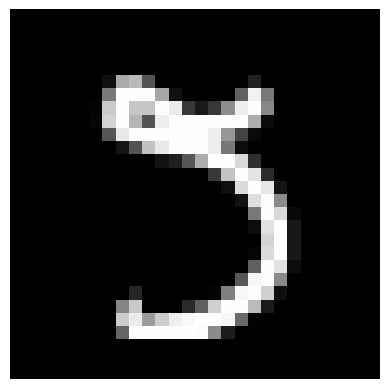

____________________________________________________________

True - 8.0, predicted - 5.0


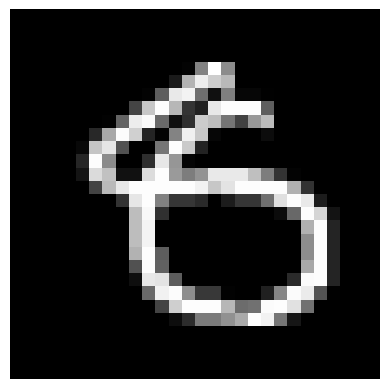

____________________________________________________________



In [64]:
# Boolean mask of misclassified samples
mask = y_val != val_rf_preds

wrong_preds_df = X_val.loc[mask].copy()
wrong_preds_df["y_true"] = y_val.loc[mask]
wrong_preds_df["y_pred"] = val_rf_preds[mask]

def show_error_details(row):
    print(f'True - {row["y_true"]}, predicted - {row["y_pred"]}')
    
    image_data = row.drop(["y_true", "y_pred"])
    show_image_matplotlib(image_data)

# show few random examples
indeces = [1, 4, 7, 14, 16, 19]

for i in indeces:
    show_error_details(wrong_preds_df.iloc[i])
    print('_'*60 + '\n')
